In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(540704, 828)
(540704, 1)
validation
(80437, 828)
(80437, 1)
test
(63506, 828)
(63506, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/55 [..............................] - ETA: 1:24 - loss: 0.0115 - STD: 1.2271e-04 - MAE: 0.0793

 4/55 [=>............................] - ETA: 1s - loss: 0.0160 - STD: 3.4696e-04 - MAE: 0.0989  

 5/55 [=>............................] - ETA: 1s - loss: 0.0165 - STD: 3.7600e-04 - MAE: 0.0990

 6/55 [==>...........................] - ETA: 2s - loss: 0.0169 - STD: 4.0181e-04 - MAE: 0.0990

 7/55 [==>...........................] - ETA: 2s - loss: 0.0170 - STD: 4.3273e-04 - MAE: 0.0984

 8/55 [===>..........................] - ETA: 2s - loss: 0.0165 - STD: 4.7117e-04 - MAE: 0.0965

 9/55 [===>..........................] - ETA: 2s - loss: 0.0160 - STD: 5.1626e-04 - MAE: 0.0947

10/55 [====>.........................] - ETA: 2s - loss: 0.0155 - STD: 5.6652e-04 - MAE: 0.0936

11/55 [=====>........................] - ETA: 2s - loss: 0.0152 - STD: 6.1736e-04 - MAE: 0.0937

12/55 [=====>........................] - ETA: 2s - loss: 0.0151 - STD: 6.6610e-04 - MAE: 0.0942

13/55 [======>.......................] - ETA: 2s - loss: 0.0150 - STD: 7.1194e-04 - MAE: 0.0947

14/55 [======>.......................] - ETA: 2s - loss: 0.0148 - STD: 7.5141e-04 - MAE: 0.0946

15/55 [=======>......................] - ETA: 2s - loss: 0.0146 - STD: 7.8346e-04 - MAE: 0.0939

16/55 [=======>......................] - ETA: 2s - loss: 0.0144 - STD: 8.0833e-04 - MAE: 0.0931

17/55 [========>.....................] - ETA: 2s - loss: 0.0142 - STD: 8.2890e-04 - MAE: 0.0922

18/55 [========>.....................] - ETA: 2s - loss: 0.0141 - STD: 8.4610e-04 - MAE: 0.0915

19/55 [=========>....................] - ETA: 1s - loss: 0.0140 - STD: 8.6191e-04 - MAE: 0.0909

20/55 [=========>....................] - ETA: 1s - loss: 0.0139 - STD: 8.7800e-04 - MAE: 0.0904

21/55 [==========>...................] - ETA: 1s - loss: 0.0138 - STD: 8.9644e-04 - MAE: 0.0898

22/55 [===========>..................] - ETA: 1s - loss: 0.0137 - STD: 9.1717e-04 - MAE: 0.0894

23/55 [===========>..................] - ETA: 1s - loss: 0.0135 - STD: 9.4128e-04 - MAE: 0.0889

24/55 [============>.................] - ETA: 2s - loss: 0.0135 - STD: 9.6977e-04 - MAE: 0.0886

27/55 [=============>................] - ETA: 2s - loss: 0.0133 - STD: 0.0011 - MAE: 0.0884    

29/55 [==============>...............] - ETA: 1s - loss: 0.0131 - STD: 0.0011 - MAE: 0.0882

30/55 [===============>..............] - ETA: 1s - loss: 0.0130 - STD: 0.0012 - MAE: 0.0880

31/55 [===============>..............] - ETA: 1s - loss: 0.0130 - STD: 0.0012 - MAE: 0.0878

32/55 [================>.............] - ETA: 1s - loss: 0.0129 - STD: 0.0012 - MAE: 0.0875

33/55 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 0.0013 - MAE: 0.0873

34/55 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 0.0013 - MAE: 0.0870

35/55 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 0.0013 - MAE: 0.0868

36/55 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 0.0013 - MAE: 0.0867

37/55 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 0.0014 - MAE: 0.0865

38/55 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 0.0014 - MAE: 0.0863

39/55 [====================>.........] - ETA: 1s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0862

40/55 [====================>.........] - ETA: 1s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0861

41/55 [=====================>........] - ETA: 0s - loss: 0.0124 - STD: 0.0016 - MAE: 0.0861

42/55 [=====================>........] - ETA: 0s - loss: 0.0124 - STD: 0.0016 - MAE: 0.0860

43/55 [======================>.......] - ETA: 0s - loss: 0.0124 - STD: 0.0017 - MAE: 0.0859

44/55 [=======================>......] - ETA: 0s - loss: 0.0123 - STD: 0.0017 - MAE: 0.0859

45/55 [=======================>......] - ETA: 0s - loss: 0.0123 - STD: 0.0018 - MAE: 0.0857

46/55 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.0019 - MAE: 0.0856

47/55 [========================>.....] - ETA: 0s - loss: 0.0122 - STD: 0.0019 - MAE: 0.0855

48/55 [=========================>....] - ETA: 0s - loss: 0.0122 - STD: 0.0020 - MAE: 0.0853

49/55 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 0.0021 - MAE: 0.0852

50/55 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 0.0021 - MAE: 0.0851

51/55 [==========================>...] - ETA: 0s - loss: 0.0121 - STD: 0.0022 - MAE: 0.0850

52/55 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 0.0023 - MAE: 0.0849

53/55 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 0.0024 - MAE: 0.0848

54/55 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 0.0025 - MAE: 0.0847

55/55 [==============================] - ETA: 0s - loss: 0.0120 - STD: 0.0026 - MAE: 0.0847

55/55 [==============================] - 6s 78ms/step - loss: 0.0120 - STD: 0.0026 - MAE: 0.0847 - val_loss: 0.0114 - val_STD: 0.0085 - val_MAE: 0.0837


Epoch 2/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0106 - STD: 0.0093 - MAE: 0.0817

 2/55 [>.............................] - ETA: 3s - loss: 0.0104 - STD: 0.0097 - MAE: 0.0809

 3/55 [>.............................] - ETA: 3s - loss: 0.0104 - STD: 0.0100 - MAE: 0.0807

 4/55 [=>............................] - ETA: 3s - loss: 0.0103 - STD: 0.0103 - MAE: 0.0803

 5/55 [=>............................] - ETA: 3s - loss: 0.0103 - STD: 0.0107 - MAE: 0.0799

 6/55 [==>...........................] - ETA: 2s - loss: 0.0103 - STD: 0.0110 - MAE: 0.0796

 7/55 [==>...........................] - ETA: 2s - loss: 0.0102 - STD: 0.0115 - MAE: 0.0794

 8/55 [===>..........................] - ETA: 2s - loss: 0.0102 - STD: 0.0119 - MAE: 0.0791

 9/55 [===>..........................] - ETA: 2s - loss: 0.0101 - STD: 0.0124 - MAE: 0.0790

10/55 [====>.........................] - ETA: 2s - loss: 0.0101 - STD: 0.0129 - MAE: 0.0789

11/55 [=====>........................] - ETA: 2s - loss: 0.0101 - STD: 0.0134 - MAE: 0.0789

12/55 [=====>........................] - ETA: 2s - loss: 0.0100 - STD: 0.0140 - MAE: 0.0788

13/55 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 0.0146 - MAE: 0.0787

14/55 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 0.0153 - MAE: 0.0787

15/55 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 0.0159 - MAE: 0.0786

16/55 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 0.0166 - MAE: 0.0785

17/55 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 0.0172 - MAE: 0.0784

18/55 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 0.0179 - MAE: 0.0782

19/55 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0186 - MAE: 0.0781

20/55 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0193 - MAE: 0.0780

21/55 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 0.0200 - MAE: 0.0779

22/55 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 0.0207 - MAE: 0.0778

23/55 [===========>..................] - ETA: 1s - loss: 0.0097 - STD: 0.0215 - MAE: 0.0777

24/55 [============>.................] - ETA: 1s - loss: 0.0097 - STD: 0.0222 - MAE: 0.0776

25/55 [============>.................] - ETA: 1s - loss: 0.0097 - STD: 0.0229 - MAE: 0.0775

26/55 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.0235 - MAE: 0.0774

27/55 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.0242 - MAE: 0.0773

28/55 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0248 - MAE: 0.0772

29/55 [==============>...............] - ETA: 1s - loss: 0.0096 - STD: 0.0254 - MAE: 0.0771

30/55 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0259 - MAE: 0.0770

31/55 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0264 - MAE: 0.0769

32/55 [================>.............] - ETA: 1s - loss: 0.0096 - STD: 0.0269 - MAE: 0.0769

33/55 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0274 - MAE: 0.0768

34/55 [=================>............] - ETA: 1s - loss: 0.0095 - STD: 0.0278 - MAE: 0.0767

35/55 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0282 - MAE: 0.0766

36/55 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.0285 - MAE: 0.0765

37/55 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.0288 - MAE: 0.0764

39/55 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 0.0294 - MAE: 0.0763

40/55 [====================>.........] - ETA: 0s - loss: 0.0095 - STD: 0.0296 - MAE: 0.0762

41/55 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0299 - MAE: 0.0761

42/55 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0301 - MAE: 0.0760

43/55 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0304 - MAE: 0.0760

44/55 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0307 - MAE: 0.0759

45/55 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0309 - MAE: 0.0758

46/55 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.0312 - MAE: 0.0757

47/55 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0315 - MAE: 0.0756

48/55 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0317 - MAE: 0.0756

49/55 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0320 - MAE: 0.0755

50/55 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0323 - MAE: 0.0754

51/55 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0326 - MAE: 0.0754

52/55 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0328 - MAE: 0.0753

53/55 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0331 - MAE: 0.0752

54/55 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0333 - MAE: 0.0751

55/55 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0335 - MAE: 0.0750

55/55 [==============================] - 4s 65ms/step - loss: 0.0092 - STD: 0.0335 - MAE: 0.0750 - val_loss: 0.0096 - val_STD: 0.0430 - val_MAE: 0.0700


Epoch 3/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0084 - STD: 0.0462 - MAE: 0.0710

 2/55 [>.............................] - ETA: 3s - loss: 0.0084 - STD: 0.0463 - MAE: 0.0709

 3/55 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.0460 - MAE: 0.0710

 4/55 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.0460 - MAE: 0.0707

 5/55 [=>............................] - ETA: 2s - loss: 0.0084 - STD: 0.0460 - MAE: 0.0706

 6/55 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.0459 - MAE: 0.0708

 7/55 [==>...........................] - ETA: 2s - loss: 0.0085 - STD: 0.0459 - MAE: 0.0707

 8/55 [===>..........................] - ETA: 2s - loss: 0.0084 - STD: 0.0460 - MAE: 0.0706

 9/55 [===>..........................] - ETA: 2s - loss: 0.0084 - STD: 0.0460 - MAE: 0.0706

10/55 [====>.........................] - ETA: 2s - loss: 0.0084 - STD: 0.0461 - MAE: 0.0705

11/55 [=====>........................] - ETA: 2s - loss: 0.0084 - STD: 0.0461 - MAE: 0.0703

12/55 [=====>........................] - ETA: 2s - loss: 0.0083 - STD: 0.0462 - MAE: 0.0702

13/55 [======>.......................] - ETA: 2s - loss: 0.0083 - STD: 0.0463 - MAE: 0.0700

14/55 [======>.......................] - ETA: 2s - loss: 0.0083 - STD: 0.0464 - MAE: 0.0700

15/55 [=======>......................] - ETA: 2s - loss: 0.0083 - STD: 0.0465 - MAE: 0.0699

16/55 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0467 - MAE: 0.0697

17/55 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0468 - MAE: 0.0696

18/55 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0470 - MAE: 0.0694

19/55 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0471 - MAE: 0.0693

20/55 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0473 - MAE: 0.0691

21/55 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.0476 - MAE: 0.0690

22/55 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.0477 - MAE: 0.0688

24/55 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0483 - MAE: 0.0684

25/55 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0486 - MAE: 0.0683

26/55 [=============>................] - ETA: 1s - loss: 0.0079 - STD: 0.0489 - MAE: 0.0681

27/55 [=============>................] - ETA: 1s - loss: 0.0079 - STD: 0.0492 - MAE: 0.0679

28/55 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0496 - MAE: 0.0678

29/55 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.0500 - MAE: 0.0677

30/55 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.0503 - MAE: 0.0675

31/55 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.0507 - MAE: 0.0675

32/55 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0510 - MAE: 0.0673

33/55 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0514 - MAE: 0.0672

34/55 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0517 - MAE: 0.0670

35/55 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0520 - MAE: 0.0669

36/55 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0525 - MAE: 0.0669

37/55 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0526 - MAE: 0.0668

38/55 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0529 - MAE: 0.0667

39/55 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0533 - MAE: 0.0667

40/55 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0534 - MAE: 0.0666

41/55 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0536 - MAE: 0.0664

42/55 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0540 - MAE: 0.0665

43/55 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0541 - MAE: 0.0664

44/55 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0542 - MAE: 0.0663

45/55 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0545 - MAE: 0.0663

46/55 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0547 - MAE: 0.0662

47/55 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0547 - MAE: 0.0661

48/55 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0548 - MAE: 0.0660

49/55 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0550 - MAE: 0.0660

50/55 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0551 - MAE: 0.0659

51/55 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0551 - MAE: 0.0658

52/55 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0553 - MAE: 0.0657

53/55 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0555 - MAE: 0.0657

54/55 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0555 - MAE: 0.0656

55/55 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0556 - MAE: 0.0655

55/55 [==============================] - 4s 64ms/step - loss: 0.0074 - STD: 0.0556 - MAE: 0.0655 - val_loss: 0.0068 - val_STD: 0.0577 - val_MAE: 0.0594


Epoch 4/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0066 - STD: 0.0638 - MAE: 0.0628

 2/55 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0639 - MAE: 0.0628

 3/55 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0621 - MAE: 0.0619

 4/55 [=>............................] - ETA: 3s - loss: 0.0066 - STD: 0.0614 - MAE: 0.0613

 5/55 [=>............................] - ETA: 3s - loss: 0.0066 - STD: 0.0621 - MAE: 0.0618

 6/55 [==>...........................] - ETA: 2s - loss: 0.0066 - STD: 0.0627 - MAE: 0.0621

 7/55 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0621 - MAE: 0.0619

 8/55 [===>..........................] - ETA: 2s - loss: 0.0067 - STD: 0.0619 - MAE: 0.0618

 9/55 [===>..........................] - ETA: 2s - loss: 0.0067 - STD: 0.0625 - MAE: 0.0621

10/55 [====>.........................] - ETA: 2s - loss: 0.0066 - STD: 0.0626 - MAE: 0.0618

12/55 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.0621 - MAE: 0.0615

13/55 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0627 - MAE: 0.0618

14/55 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0627 - MAE: 0.0617

15/55 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0625 - MAE: 0.0615

16/55 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0628 - MAE: 0.0615

17/55 [========>.....................] - ETA: 2s - loss: 0.0066 - STD: 0.0631 - MAE: 0.0616

18/55 [========>.....................] - ETA: 2s - loss: 0.0066 - STD: 0.0630 - MAE: 0.0615

19/55 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0630 - MAE: 0.0614

20/55 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0633 - MAE: 0.0615

21/55 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0634 - MAE: 0.0614

22/55 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0633 - MAE: 0.0613

23/55 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0635 - MAE: 0.0613

24/55 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0637 - MAE: 0.0613

25/55 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0637 - MAE: 0.0612

26/55 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0637 - MAE: 0.0611

27/55 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0639 - MAE: 0.0611

28/55 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0640 - MAE: 0.0611

29/55 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0640 - MAE: 0.0610

30/55 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0641 - MAE: 0.0609

31/55 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0642 - MAE: 0.0609

32/55 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0642 - MAE: 0.0609

33/55 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0642 - MAE: 0.0608

34/55 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0644 - MAE: 0.0608

35/55 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0644 - MAE: 0.0608

36/55 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0644 - MAE: 0.0608

37/55 [===================>..........] - ETA: 1s - loss: 0.0065 - STD: 0.0645 - MAE: 0.0607

38/55 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0646 - MAE: 0.0607

39/55 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0646 - MAE: 0.0606

40/55 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0646 - MAE: 0.0606

41/55 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0647 - MAE: 0.0606

42/55 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0648 - MAE: 0.0605

43/55 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0648 - MAE: 0.0605

44/55 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0649 - MAE: 0.0604

45/55 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0649 - MAE: 0.0604

46/55 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0650 - MAE: 0.0604

47/55 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0650 - MAE: 0.0603

48/55 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0651 - MAE: 0.0603

49/55 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0652 - MAE: 0.0603

50/55 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0652 - MAE: 0.0603

51/55 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0653 - MAE: 0.0602

52/55 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0653 - MAE: 0.0602

53/55 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0654 - MAE: 0.0602

54/55 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0655 - MAE: 0.0601

55/55 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0655 - MAE: 0.0601

55/55 [==============================] - 3s 62ms/step - loss: 0.0064 - STD: 0.0655 - MAE: 0.0601 - val_loss: 0.0063 - val_STD: 0.0622 - val_MAE: 0.0549


Epoch 5/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0667 - MAE: 0.0577

 2/55 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0687 - MAE: 0.0584

 3/55 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0680 - MAE: 0.0581

 4/55 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0681 - MAE: 0.0580

 5/55 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0580

 6/55 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0682 - MAE: 0.0580

 7/55 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0684 - MAE: 0.0580

 8/55 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0580

 9/55 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0580

10/55 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0578

11/55 [=====>........................] - ETA: 2s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0579

12/55 [=====>........................] - ETA: 2s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0578

13/55 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0577

14/55 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0578

15/55 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0578

16/55 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0578

17/55 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0578

18/55 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0577

19/55 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0578

20/55 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0577

21/55 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0577

22/55 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0576

23/55 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0576

24/55 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0576

25/55 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0575

26/55 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0576

27/55 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0575

28/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0575

29/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0575

30/55 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0575

31/55 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0692 - MAE: 0.0574

32/55 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0692 - MAE: 0.0574

33/55 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0693 - MAE: 0.0574

35/55 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0691 - MAE: 0.0573

36/55 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0693 - MAE: 0.0574

37/55 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0575

38/55 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0578

39/55 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0579

40/55 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0578

41/55 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0582

42/55 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0585

43/55 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0585

44/55 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0687 - MAE: 0.0593

45/55 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0684 - MAE: 0.0593

46/55 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0678 - MAE: 0.0595

47/55 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0676 - MAE: 0.0594

48/55 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0677 - MAE: 0.0598

49/55 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0675 - MAE: 0.0598

50/55 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0670 - MAE: 0.0599

51/55 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0667 - MAE: 0.0599

52/55 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0665 - MAE: 0.0599

53/55 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0601

54/55 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0601

55/55 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0659 - MAE: 0.0601

55/55 [==============================] - 3s 62ms/step - loss: 0.0065 - STD: 0.0659 - MAE: 0.0601 - val_loss: 0.0078 - val_STD: 0.0464 - val_MAE: 0.0595


Epoch 6/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0070 - STD: 0.0488 - MAE: 0.0599

 2/55 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0522 - MAE: 0.0598

 3/55 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0555 - MAE: 0.0622

 4/55 [=>............................] - ETA: 3s - loss: 0.0066 - STD: 0.0568 - MAE: 0.0625

 5/55 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0564 - MAE: 0.0617

 6/55 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0558 - MAE: 0.0610

 7/55 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0561 - MAE: 0.0607

 8/55 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0572 - MAE: 0.0608

 9/55 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0581 - MAE: 0.0609

10/55 [====>.........................] - ETA: 2s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0605

11/55 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0603

12/55 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0601

13/55 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0600

14/55 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0600 - MAE: 0.0600

15/55 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0597

16/55 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0606 - MAE: 0.0595

17/55 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0609 - MAE: 0.0594

18/55 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0614 - MAE: 0.0593

19/55 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0592

20/55 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0621 - MAE: 0.0590

21/55 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0623 - MAE: 0.0589

22/55 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0627 - MAE: 0.0588

23/55 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0631 - MAE: 0.0587

24/55 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0634 - MAE: 0.0586

26/55 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0638 - MAE: 0.0584

27/55 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0642 - MAE: 0.0584

28/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0646 - MAE: 0.0583

29/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0649 - MAE: 0.0583

30/55 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0651 - MAE: 0.0582

31/55 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0653 - MAE: 0.0581

32/55 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0656 - MAE: 0.0581

33/55 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0659 - MAE: 0.0580

34/55 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0661 - MAE: 0.0579

35/55 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0663 - MAE: 0.0579

36/55 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0665 - MAE: 0.0578

37/55 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0667 - MAE: 0.0578

38/55 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0669 - MAE: 0.0577

39/55 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0670 - MAE: 0.0577

40/55 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0672 - MAE: 0.0577

41/55 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0673 - MAE: 0.0576

42/55 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0674 - MAE: 0.0575

43/55 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0676 - MAE: 0.0575

44/55 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0677 - MAE: 0.0575

45/55 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0677 - MAE: 0.0575

46/55 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0678 - MAE: 0.0574

47/55 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0679 - MAE: 0.0574

48/55 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0680 - MAE: 0.0573

49/55 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0680 - MAE: 0.0573

50/55 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0681 - MAE: 0.0573

51/55 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0682 - MAE: 0.0572

52/55 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0682 - MAE: 0.0571

53/55 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0682 - MAE: 0.0571

54/55 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0683 - MAE: 0.0571

55/55 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0684 - MAE: 0.0571

55/55 [==============================] - 4s 64ms/step - loss: 0.0058 - STD: 0.0684 - MAE: 0.0571 - val_loss: 0.0059 - val_STD: 0.0669 - val_MAE: 0.0526


Epoch 7/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0701 - MAE: 0.0548

 2/55 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0551

 3/55 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0552

 4/55 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0550

 5/55 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0549

 6/55 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0548

 7/55 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0548

 8/55 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0550

10/55 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0554

11/55 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0554

12/55 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0720 - MAE: 0.0553

13/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0554

14/55 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0555

15/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0554

16/55 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0554

17/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0555

18/55 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0555

19/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0554

20/55 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0555

21/55 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0555

22/55 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0554

23/55 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0554

24/55 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0554

25/55 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0554

26/55 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0554

27/55 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0554

28/55 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0553

29/55 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0553

30/55 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0553

31/55 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0553

32/55 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0552

33/55 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0552

34/55 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0552

35/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0552

36/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0551

37/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0552

38/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0552

39/55 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0551

40/55 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0551

41/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0551

42/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0550

43/55 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0550

44/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0550

45/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0550

46/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0550

47/55 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0550

48/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0550

49/55 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0550

50/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0550

51/55 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0550

52/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0549

53/55 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0549

54/55 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0549

55/55 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0549

55/55 [==============================] - 4s 66ms/step - loss: 0.0055 - STD: 0.0730 - MAE: 0.0549 - val_loss: 0.0057 - val_STD: 0.0705 - val_MAE: 0.0516


Epoch 8/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0527

 2/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0535

 3/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0741 - MAE: 0.0536

 4/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0538

 5/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0538

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0538

 7/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0743 - MAE: 0.0539

 8/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0539

 9/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0743 - MAE: 0.0538

10/55 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0539

11/55 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0539

12/55 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0539

13/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

14/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0743 - MAE: 0.0540

15/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

16/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

17/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

19/55 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0539

20/55 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0540

21/55 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0742 - MAE: 0.0540

22/55 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0746 - MAE: 0.0544

23/55 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0741 - MAE: 0.0545

24/55 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0546

25/55 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0743 - MAE: 0.0546

26/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0741 - MAE: 0.0545

27/55 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0742 - MAE: 0.0546

28/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0545

29/55 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0545

30/55 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0545

31/55 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0737 - MAE: 0.0545

32/55 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0738 - MAE: 0.0546

33/55 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0737 - MAE: 0.0546

34/55 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0545

35/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0546

36/55 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0546

37/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0546

38/55 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0735 - MAE: 0.0546

39/55 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0547

40/55 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0547

41/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0547

42/55 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0547

43/55 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0547

44/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0546

45/55 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0546

46/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0546

47/55 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0733 - MAE: 0.0546

48/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0545

49/55 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0545

50/55 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0545

51/55 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0545

52/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0545

53/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0545

54/55 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0545

55/55 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0545

55/55 [==============================] - 4s 71ms/step - loss: 0.0054 - STD: 0.0736 - MAE: 0.0545 - val_loss: 0.0055 - val_STD: 0.0720 - val_MAE: 0.0513


Epoch 9/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0533

 2/55 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0540

 3/55 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0755 - MAE: 0.0538

 4/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0536

 5/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0754 - MAE: 0.0539

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0754 - MAE: 0.0538

 7/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0537

 8/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0756 - MAE: 0.0537

 9/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0536

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0537

11/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0536

12/55 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0754 - MAE: 0.0537

13/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0536

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0535

15/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0534

16/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

17/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0535

18/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

19/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0535

20/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

22/55 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

23/55 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

24/55 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

25/55 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

26/55 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0533

27/55 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

28/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0534

29/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

30/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0534

31/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

32/55 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

33/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

34/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

35/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

36/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0534

37/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

38/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0534

39/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0534

40/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

41/55 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0537

42/55 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0538

43/55 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0538

44/55 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0538

45/55 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0539

46/55 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0540

47/55 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0540

48/55 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0540

49/55 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0540

50/55 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0541

51/55 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0541

52/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0746 - MAE: 0.0541

53/55 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0541

54/55 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0541

55/55 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540

55/55 [==============================] - 4s 73ms/step - loss: 0.0053 - STD: 0.0745 - MAE: 0.0540 - val_loss: 0.0055 - val_STD: 0.0737 - val_MAE: 0.0538


Epoch 10/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0562

 2/55 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0722 - MAE: 0.0546

 3/55 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0716 - MAE: 0.0543

 4/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0725 - MAE: 0.0544

 5/55 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0720 - MAE: 0.0543

 6/55 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0726 - MAE: 0.0544

 7/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0731 - MAE: 0.0543

 8/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0728 - MAE: 0.0540

 9/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0736 - MAE: 0.0541

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0736 - MAE: 0.0538

11/55 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0736 - MAE: 0.0537

12/55 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0742 - MAE: 0.0539

13/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0736 - MAE: 0.0540

14/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0541

15/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

16/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0742 - MAE: 0.0539

17/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0540

18/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0539

19/55 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0538

20/55 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0538

21/55 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0537

22/55 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0537

24/55 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0536

25/55 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0537

26/55 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0536

27/55 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0536

28/55 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0536

29/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0536

30/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0536

31/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0535

32/55 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0535

33/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0535

34/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0534

35/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0534

36/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0533

37/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0533

38/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0533

39/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0533

40/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0533

41/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0533

42/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0532

43/55 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0532

44/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0532

45/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0532

46/55 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0532

47/55 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0533

48/55 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0533

49/55 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0533

50/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0533

51/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0533

52/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0533

53/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0533

54/55 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0532

55/55 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0532

55/55 [==============================] - 4s 73ms/step - loss: 0.0052 - STD: 0.0752 - MAE: 0.0532 - val_loss: 0.0056 - val_STD: 0.0813 - val_MAE: 0.0548


Epoch 11/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0821 - MAE: 0.0564

 2/55 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0549

 3/55 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0545

 4/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0766 - MAE: 0.0540

 5/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0537

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0541

 7/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0754 - MAE: 0.0538

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0539

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0537

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0535

11/55 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0536

12/55 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0535

13/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0536

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0535

15/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0534

16/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0535

17/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

18/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0757 - MAE: 0.0537

19/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0537

20/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0536

21/55 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0537

22/55 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0536

23/55 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0537

24/55 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

25/55 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0536

26/55 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

27/55 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0535

28/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

29/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0535

30/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0535

31/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

32/55 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0536

33/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

34/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

35/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0535

36/55 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0536

37/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0535

38/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0535

39/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0535

40/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0534

41/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0534

42/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0534

43/55 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0533

44/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0533

45/55 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0534

46/55 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0534

47/55 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0535

49/55 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0534

50/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0534

51/55 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0534

52/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0534

53/55 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0534

54/55 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0534

55/55 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0534

55/55 [==============================] - 4s 73ms/step - loss: 0.0052 - STD: 0.0755 - MAE: 0.0534 - val_loss: 0.0062 - val_STD: 0.0660 - val_MAE: 0.0526


Epoch 12/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0673 - MAE: 0.0526

 2/55 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0725 - MAE: 0.0533

 3/55 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0539

 4/55 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0541

 5/55 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0543

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0739 - MAE: 0.0538

 7/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0733 - MAE: 0.0536

 8/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0540

 9/55 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0738 - MAE: 0.0538

10/55 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0738 - MAE: 0.0536

12/55 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0539

13/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0742 - MAE: 0.0538

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0745 - MAE: 0.0538

15/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0538

16/55 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0742 - MAE: 0.0538

17/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0538

18/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0741 - MAE: 0.0537

19/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0743 - MAE: 0.0538

20/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0743 - MAE: 0.0537

21/55 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0742 - MAE: 0.0536

22/55 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0536

23/55 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0535

24/55 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0744 - MAE: 0.0535

25/55 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0535

26/55 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0534

27/55 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0746 - MAE: 0.0534

28/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0533

29/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0533

30/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0532

31/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0533

32/55 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0532

33/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0532

34/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0532

35/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0531

36/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0531

37/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0531

38/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0531

39/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0530

40/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0530

41/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0530

42/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0530

43/55 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0530

44/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0529

45/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0529

46/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0529

47/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0529

48/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0529

49/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0528

50/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0528

51/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0528

52/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0528

53/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

54/55 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0528

55/55 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

55/55 [==============================] - 4s 73ms/step - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529 - val_loss: 0.0058 - val_STD: 0.0698 - val_MAE: 0.0516


Epoch 13/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0717 - MAE: 0.0510

 2/55 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0747 - MAE: 0.0519

 3/55 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0770 - MAE: 0.0528

 4/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0742 - MAE: 0.0530

 5/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0536

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0755 - MAE: 0.0534

 7/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0532

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0533

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0532

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0531

11/55 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0530

12/55 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0529

13/55 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0530

14/55 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0529

15/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0528

16/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0530

17/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0530

18/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0531

19/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0530

20/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0529

21/55 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0530

22/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0530

23/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0530

24/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

25/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0528

26/55 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

27/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0529

28/55 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

29/55 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

30/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

31/55 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

32/55 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

33/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

34/55 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

35/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

36/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

37/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

38/55 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0528

39/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0528

40/55 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0527

41/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0528

42/55 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0527

43/55 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0527

44/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0527

45/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0527

46/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0527

47/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0526

49/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0525

50/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0526

51/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0525

52/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0525

53/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0525

54/55 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0525

55/55 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0525

55/55 [==============================] - 4s 72ms/step - loss: 0.0051 - STD: 0.0764 - MAE: 0.0525 - val_loss: 0.0055 - val_STD: 0.0732 - val_MAE: 0.0508


Epoch 14/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0510

 2/55 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0782 - MAE: 0.0530

 3/55 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0525

 4/55 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0527

 5/55 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0769 - MAE: 0.0527

 6/55 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0526

 7/55 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0530

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0530

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0531

10/55 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0529

11/55 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0766 - MAE: 0.0532

13/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0532

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0532

15/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0764 - MAE: 0.0532

16/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0531

17/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0531

18/55 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

19/55 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0530

20/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0530

21/55 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0529

22/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

23/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0529

24/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0529

25/55 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0530

26/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

27/55 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

29/55 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0529

30/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

31/55 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0529

32/55 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0529

33/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0530

34/55 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0529

35/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

36/55 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0530

37/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0530

38/55 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

39/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0530

40/55 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0530

41/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0760 - MAE: 0.0530

42/55 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0530

43/55 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0530

44/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

45/55 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

46/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0529

47/55 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

48/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0529

49/55 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0759 - MAE: 0.0528

50/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

51/55 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

52/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0528

53/55 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0528

54/55 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0527

55/55 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0527

55/55 [==============================] - 4s 72ms/step - loss: 0.0051 - STD: 0.0761 - MAE: 0.0527 - val_loss: 0.0052 - val_STD: 0.0789 - val_MAE: 0.0512


Epoch 15/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0519

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0514

 3/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0516

 4/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0514

 5/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0515

 6/55 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0514

 7/55 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0515

 9/55 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0515

10/55 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0518

11/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0516

12/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0516

13/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0518

14/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0519

15/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0520

16/55 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0520

17/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0520

18/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0521

19/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0521

20/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0520

21/55 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0520

22/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0520

23/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0520

24/55 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0521

25/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0520

26/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0520

27/55 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0519

28/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

29/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0519

30/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

31/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0519

32/55 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0519

33/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0519

34/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0519

35/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0519

36/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0519

37/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0518

38/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0518

39/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

40/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0518

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0518

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0518

53/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0518

54/55 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0518

55/55 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0517

55/55 [==============================] - 4s 72ms/step - loss: 0.0049 - STD: 0.0777 - MAE: 0.0517 - val_loss: 0.0053 - val_STD: 0.0763 - val_MAE: 0.0503


Epoch 16/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0513

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0513

 3/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0513

 4/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0785 - MAE: 0.0518

 5/55 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0516

 6/55 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0783 - MAE: 0.0517

 7/55 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0517

 8/55 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0780 - MAE: 0.0519

 9/55 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0517

10/55 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0517

11/55 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0517

12/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0517

13/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0516

14/55 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0780 - MAE: 0.0517

15/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0516

16/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0782 - MAE: 0.0518

17/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0519

18/55 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0781 - MAE: 0.0521

19/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0521

20/55 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0778 - MAE: 0.0522

21/55 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0521

22/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0520

23/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0777 - MAE: 0.0521

24/55 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0520

25/55 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0520

26/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0520

27/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0520

28/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0520

29/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0519

30/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0776 - MAE: 0.0520

31/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0520

32/55 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0520

33/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0519

34/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0519

35/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0519

36/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0519

37/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0519

38/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0518

39/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

40/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0517

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0517

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0517

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0517

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0517

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0517

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0517

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0517

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0517

53/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0517

54/55 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0517

55/55 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0517

55/55 [==============================] - 4s 71ms/step - loss: 0.0049 - STD: 0.0779 - MAE: 0.0517 - val_loss: 0.0053 - val_STD: 0.0748 - val_MAE: 0.0500


Epoch 17/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0509

 2/55 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0525

 3/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0528

 4/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0786 - MAE: 0.0538

 5/55 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0765 - MAE: 0.0537

 6/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0540

 7/55 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0771 - MAE: 0.0535

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0532

 9/55 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0774 - MAE: 0.0531

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0765 - MAE: 0.0530

11/55 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0532

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0766 - MAE: 0.0531

13/55 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0530

14/55 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0768 - MAE: 0.0529

16/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0529

17/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0528

18/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0528

19/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0527

20/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0762 - MAE: 0.0526

21/55 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0526

22/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0526

23/55 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0526

24/55 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0764 - MAE: 0.0525

25/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0524

26/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0524

27/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0765 - MAE: 0.0524

28/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0766 - MAE: 0.0524

29/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0766 - MAE: 0.0523

30/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0766 - MAE: 0.0522

31/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0522

32/55 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0521

33/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0521

34/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0521

35/55 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0521

36/55 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0521

37/55 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0520

38/55 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0520

39/55 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0520

40/55 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0520

41/55 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0520

42/55 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0520

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0519

44/55 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0519

45/55 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0519

46/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0520

47/55 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0520

48/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0520

49/55 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0519

50/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0519

51/55 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0519

52/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0519

53/55 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0774 - MAE: 0.0519

54/55 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0519

55/55 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0519

55/55 [==============================] - 4s 72ms/step - loss: 0.0049 - STD: 0.0774 - MAE: 0.0519 - val_loss: 0.0051 - val_STD: 0.0758 - val_MAE: 0.0498


Epoch 18/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0510

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0510

 4/55 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0765 - MAE: 0.0502

 5/55 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0783 - MAE: 0.0514

 6/55 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0760 - MAE: 0.0518

 7/55 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0773 - MAE: 0.0521

 8/55 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0775 - MAE: 0.0520

 9/55 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0520

10/55 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0526

11/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0767 - MAE: 0.0528

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0768 - MAE: 0.0528

13/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0529

14/55 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0530

15/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0764 - MAE: 0.0529

16/55 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0768 - MAE: 0.0531

17/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0759 - MAE: 0.0533

18/55 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0759 - MAE: 0.0532

19/55 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0764 - MAE: 0.0536

20/55 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0538

21/55 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0752 - MAE: 0.0537

22/55 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0548

23/55 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0746 - MAE: 0.0555

24/55 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0561

25/55 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0739 - MAE: 0.0567

26/55 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0739 - MAE: 0.0567

27/55 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0730 - MAE: 0.0568

28/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0568

29/55 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0723 - MAE: 0.0570

30/55 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0722 - MAE: 0.0571

31/55 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0716 - MAE: 0.0570

32/55 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0570

33/55 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0709 - MAE: 0.0570

34/55 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0710 - MAE: 0.0572

35/55 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0707 - MAE: 0.0571

36/55 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0702 - MAE: 0.0570

37/55 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0701 - MAE: 0.0569

38/55 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0702 - MAE: 0.0570

39/55 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0702 - MAE: 0.0570

40/55 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0699 - MAE: 0.0569

41/55 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0697 - MAE: 0.0568

42/55 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0698 - MAE: 0.0568

43/55 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0699 - MAE: 0.0568

44/55 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0567

45/55 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0696 - MAE: 0.0566

46/55 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0697 - MAE: 0.0565

47/55 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0565

48/55 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0699 - MAE: 0.0565

49/55 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0564

50/55 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0700 - MAE: 0.0563

51/55 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0563

52/55 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0562

53/55 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0703 - MAE: 0.0561

54/55 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0704 - MAE: 0.0561

55/55 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0706 - MAE: 0.0560

55/55 [==============================] - 4s 73ms/step - loss: 0.0057 - STD: 0.0706 - MAE: 0.0560 - val_loss: 0.0054 - val_STD: 0.0729 - val_MAE: 0.0499


Epoch 19/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0752 - MAE: 0.0513

 2/55 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0747 - MAE: 0.0512

 3/55 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0519

 4/55 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0781 - MAE: 0.0522

 5/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0518

 6/55 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0516

 7/55 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0518

 8/55 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0518

 9/55 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0517

10/55 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0517

11/55 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0519

12/55 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0519

13/55 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0519

14/55 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0519

15/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0519

16/55 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0518

17/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0518

18/55 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0518

19/55 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0519

20/55 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0518

21/55 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0517

22/55 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0518

23/55 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0518

24/55 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0517

25/55 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0517

26/55 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0518

27/55 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0518

28/55 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0517

30/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0517

31/55 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0517

32/55 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0767 - MAE: 0.0516

33/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0516

34/55 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0516

35/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0516

36/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0770 - MAE: 0.0516

37/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0516

38/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0516

39/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0516

40/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0516

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0515

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0515

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0514

49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0514

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0513

52/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0513

53/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0513

54/55 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0513

55/55 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0513

55/55 [==============================] - 4s 72ms/step - loss: 0.0048 - STD: 0.0777 - MAE: 0.0513 - val_loss: 0.0052 - val_STD: 0.0775 - val_MAE: 0.0494


Epoch 20/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0510

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0786 - MAE: 0.0509

 3/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0508

 4/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0508

 6/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0509

 7/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0509

 8/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0508

 9/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0508

10/55 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0508

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0508

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0508

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0508

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0508

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0508

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0508

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0508

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0508

20/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0508

21/55 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0508

22/55 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

23/55 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

24/55 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

25/55 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

26/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

27/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

28/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0506

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0506

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0506

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0506

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0506

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0506

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0506

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0505

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0506

38/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

39/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

40/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0505

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

55/55 [==============================] - 4s 72ms/step - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505 - val_loss: 0.0051 - val_STD: 0.0771 - val_MAE: 0.0492


Epoch 21/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0494

 2/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0499

 3/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0501

 4/55 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0502

 5/55 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

 6/55 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0799 - MAE: 0.0504

 7/55 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0505

 8/55 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0505

 9/55 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0504

10/55 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0503

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0504

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0504

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0797 - MAE: 0.0504

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0503

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0800 - MAE: 0.0506

17/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0506

18/55 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0506

19/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0506

20/55 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0507

21/55 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0795 - MAE: 0.0507

22/55 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0796 - MAE: 0.0507

23/55 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0792 - MAE: 0.0507

24/55 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0508

25/55 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0794 - MAE: 0.0508

26/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0508

27/55 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0792 - MAE: 0.0508

28/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0793 - MAE: 0.0509

29/55 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

30/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0509

31/55 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0509

32/55 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

33/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

34/55 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

35/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

36/55 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

37/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

38/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0508

39/55 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0507

40/55 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0507

41/55 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0507

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

43/55 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0790 - MAE: 0.0507

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

55/55 [==============================] - 4s 71ms/step - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507 - val_loss: 0.0051 - val_STD: 0.0784 - val_MAE: 0.0491


Epoch 22/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0501

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0504

 3/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0513

 4/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0783 - MAE: 0.0512

 5/55 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0513

 6/55 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0511

 7/55 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0787 - MAE: 0.0510

 8/55 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0510

 9/55 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0508

10/55 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0506

11/55 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0505

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0505

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0504

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0504

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0504

20/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

21/55 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

22/55 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

23/55 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

24/55 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

25/55 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

26/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0505

27/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

28/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0504

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0504

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0504

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0504

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0504

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0504

38/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0504

39/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0503

40/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0503

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0503

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0503

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0504

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0504

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0504

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504

55/55 [==============================] - 4s 72ms/step - loss: 0.0047 - STD: 0.0793 - MAE: 0.0504 - val_loss: 0.0050 - val_STD: 0.0806 - val_MAE: 0.0494


Epoch 23/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0510

 2/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0505

 3/55 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0791 - MAE: 0.0511

 4/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0509

 5/55 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0786 - MAE: 0.0510

 6/55 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0508

 7/55 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0784 - MAE: 0.0506

 8/55 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0507

 9/55 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

10/55 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0506

11/55 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0506

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0505

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0505

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0503

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0503

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0503

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

20/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0503

21/55 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0503

22/55 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0502

23/55 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0502

24/55 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0502

25/55 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0502

26/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0792 - MAE: 0.0502

27/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0791 - MAE: 0.0501

28/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0793 - MAE: 0.0502

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0502

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0502

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0502

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0502

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

39/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0502

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0502

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0502

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0502

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0503

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0503

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0504

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0503

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0503

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0793 - MAE: 0.0503

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0503

55/55 [==============================] - 4s 70ms/step - loss: 0.0047 - STD: 0.0794 - MAE: 0.0503 - val_loss: 0.0053 - val_STD: 0.0722 - val_MAE: 0.0491


Epoch 24/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0732 - MAE: 0.0500

 2/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0775 - MAE: 0.0506

 3/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0502

 4/55 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0771 - MAE: 0.0502

 5/55 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0506

 6/55 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0505

 7/55 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0505

 8/55 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0505

 9/55 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0505

10/55 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0507

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0785 - MAE: 0.0506

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0505

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0505

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0503

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0786 - MAE: 0.0503

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

20/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

21/55 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0502

22/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0502

23/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0501

24/55 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0502

25/55 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0502

26/55 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0502

28/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0503

29/55 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

30/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0503

31/55 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0503

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0503

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0787 - MAE: 0.0504

38/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

39/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

40/55 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0505

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0788 - MAE: 0.0504

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0504

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0504

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0503

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0503

55/55 [==============================] - 4s 72ms/step - loss: 0.0047 - STD: 0.0790 - MAE: 0.0503 - val_loss: 0.0050 - val_STD: 0.0789 - val_MAE: 0.0484


Epoch 25/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0498

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0795 - MAE: 0.0495

 3/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0497

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0499

 6/55 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0817 - MAE: 0.0512

 7/55 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0520

 8/55 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0521

 9/55 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0524

10/55 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0782 - MAE: 0.0531

11/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0529

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0531

13/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0536

14/55 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0533

15/55 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0785 - MAE: 0.0540

16/55 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0545

17/55 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0763 - MAE: 0.0544

18/55 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0563

19/55 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0757 - MAE: 0.0572

20/55 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0582

21/55 [==========>...................] - ETA: 2s - loss: 0.0063 - STD: 0.0737 - MAE: 0.0580

22/55 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0743 - MAE: 0.0599

23/55 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0730 - MAE: 0.0600

24/55 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0713 - MAE: 0.0610

25/55 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0699 - MAE: 0.0612

26/55 [=============>................] - ETA: 1s - loss: 0.0070 - STD: 0.0695 - MAE: 0.0612

27/55 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0695 - MAE: 0.0624

28/55 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0689 - MAE: 0.0624

29/55 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0679 - MAE: 0.0624

30/55 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0667 - MAE: 0.0626

31/55 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.0658 - MAE: 0.0626

32/55 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0652 - MAE: 0.0625

33/55 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0650 - MAE: 0.0629

34/55 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0649 - MAE: 0.0633

35/55 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0645 - MAE: 0.0632

36/55 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0639 - MAE: 0.0631

37/55 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0632 - MAE: 0.0631

38/55 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0627 - MAE: 0.0631

39/55 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0624 - MAE: 0.0630

40/55 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0624 - MAE: 0.0631

41/55 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0625 - MAE: 0.0632

42/55 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0624 - MAE: 0.0632

43/55 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0621 - MAE: 0.0630

44/55 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0618 - MAE: 0.0629

45/55 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0616 - MAE: 0.0628

46/55 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0615 - MAE: 0.0627

47/55 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0615 - MAE: 0.0626

48/55 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0616 - MAE: 0.0626

49/55 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0616 - MAE: 0.0625

50/55 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0615 - MAE: 0.0623

51/55 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0614 - MAE: 0.0622

52/55 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0614 - MAE: 0.0620

53/55 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0615 - MAE: 0.0619

54/55 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0617 - MAE: 0.0619

55/55 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0618 - MAE: 0.0617

55/55 [==============================] - 4s 72ms/step - loss: 0.0068 - STD: 0.0618 - MAE: 0.0617 - val_loss: 0.0058 - val_STD: 0.0629 - val_MAE: 0.0521


Epoch 26/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0536

 2/55 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0532

 3/55 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0534

 4/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0689 - MAE: 0.0538

 5/55 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0705 - MAE: 0.0539

 6/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0707 - MAE: 0.0537

 7/55 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0710 - MAE: 0.0536

 8/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0534

 9/55 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0726 - MAE: 0.0535

10/55 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0735 - MAE: 0.0534

11/55 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0738 - MAE: 0.0533

12/55 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0739 - MAE: 0.0532

13/55 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0741 - MAE: 0.0532

14/55 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0745 - MAE: 0.0532

15/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0531

16/55 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0530

17/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0529

18/55 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0527

20/55 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0528

21/55 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0527

22/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0753 - MAE: 0.0527

23/55 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0754 - MAE: 0.0526

24/55 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0526

25/55 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0525

26/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0754 - MAE: 0.0524

27/55 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0754 - MAE: 0.0524

28/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0754 - MAE: 0.0523

29/55 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0523

30/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0523

31/55 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0523

32/55 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0522

33/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0522

34/55 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0522

35/55 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0755 - MAE: 0.0521

36/55 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0755 - MAE: 0.0521

37/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0756 - MAE: 0.0520

38/55 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0756 - MAE: 0.0520

39/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0756 - MAE: 0.0519

40/55 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0519

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0518

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0758 - MAE: 0.0518

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0518

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0759 - MAE: 0.0517

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0517

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0517

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0761 - MAE: 0.0516

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0762 - MAE: 0.0516

49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0763 - MAE: 0.0516

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0516

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0764 - MAE: 0.0515

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0765 - MAE: 0.0515

53/55 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0765 - MAE: 0.0514

54/55 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0514

55/55 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0767 - MAE: 0.0514

55/55 [==============================] - 4s 71ms/step - loss: 0.0048 - STD: 0.0767 - MAE: 0.0514 - val_loss: 0.0051 - val_STD: 0.0773 - val_MAE: 0.0486


Epoch 27/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

 2/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0501

 3/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0799 - MAE: 0.0501

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0501

 5/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0499

 6/55 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0499

 7/55 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0500

 8/55 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0499

 9/55 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0499

10/55 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0499

11/55 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0499

12/55 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0499

13/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0499

14/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0500

15/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0499

16/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0499

17/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0499

18/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0499

19/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0499

20/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0498

21/55 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

22/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

23/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

24/55 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

25/55 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

26/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

27/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

28/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

29/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

31/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

32/55 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0498

33/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

34/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0795 - MAE: 0.0497

35/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

36/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

37/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

38/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

39/55 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0498

40/55 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0498

41/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

42/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

43/55 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

44/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0796 - MAE: 0.0497

45/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0497

47/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0497

48/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0497

49/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0497

50/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

51/55 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

52/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

53/55 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

54/55 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0798 - MAE: 0.0497

55/55 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496

55/55 [==============================] - 4s 72ms/step - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496 - val_loss: 0.0050 - val_STD: 0.0804 - val_MAE: 0.0484


Epoch 28/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0491

 2/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0804 - MAE: 0.0490

 3/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0492

 4/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0491

 5/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0490

 6/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0491

 7/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0491

 8/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0491

 9/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0491

10/55 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0492

11/55 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0492

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0492

13/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

14/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

15/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

25/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

26/55 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

27/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

29/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

30/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0493

31/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

32/55 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

33/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0494

34/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

35/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

36/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

37/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

38/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

39/55 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0493

40/55 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

41/55 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

42/55 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0493

43/55 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

44/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

45/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

46/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

47/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0806 - MAE: 0.0493

48/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0494

49/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

51/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0494

52/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0494

53/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0494

54/55 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0494

55/55 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0494

55/55 [==============================] - 4s 72ms/step - loss: 0.0045 - STD: 0.0807 - MAE: 0.0494 - val_loss: 0.0050 - val_STD: 0.0780 - val_MAE: 0.0482


Epoch 29/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0786 - MAE: 0.0490

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0496

 3/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0495

 4/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0493

 5/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

 6/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0493

 7/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0492

 8/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

 9/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0492

10/55 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

11/55 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0494

13/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

14/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0496

15/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0496

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0496

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0496

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0495

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0495

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0495

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0495

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

25/55 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0495

26/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0495

27/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

29/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

30/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

31/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

32/55 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

33/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

34/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

35/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

36/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0494

37/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

38/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

39/55 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

40/55 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0493

41/55 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0493

42/55 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0494

43/55 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493

44/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493

45/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493

46/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493

47/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493

48/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

49/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

50/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

51/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

52/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

53/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

54/55 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

55/55 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493

55/55 [==============================] - 4s 70ms/step - loss: 0.0045 - STD: 0.0805 - MAE: 0.0493 - val_loss: 0.0050 - val_STD: 0.0835 - val_MAE: 0.0490


Epoch 30/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0845 - MAE: 0.0498

 2/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0494

 3/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0816 - MAE: 0.0493

 4/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0494

 5/55 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0816 - MAE: 0.0492

 6/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0492

 7/55 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0492

 8/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0492

 9/55 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0491

10/55 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0491

11/55 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0492

12/55 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0492

13/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0491

14/55 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0491

15/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0490

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0490

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0490

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0490

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0491

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0490

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0492

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0493

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0493

25/55 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0813 - MAE: 0.0494

26/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0494

27/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0494

28/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0495

29/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0496

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0496

31/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0497

32/55 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0497

33/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0806 - MAE: 0.0497

34/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0499

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0804 - MAE: 0.0501

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0802 - MAE: 0.0500

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0504

38/55 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0506

39/55 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0797 - MAE: 0.0506

40/55 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0511

41/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0511

42/55 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0792 - MAE: 0.0511

43/55 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0512

44/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0793 - MAE: 0.0513

45/55 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0789 - MAE: 0.0513

46/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0787 - MAE: 0.0513

47/55 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0787 - MAE: 0.0514

48/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0786 - MAE: 0.0514

49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0783 - MAE: 0.0514

50/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0782 - MAE: 0.0514

51/55 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0782 - MAE: 0.0514

52/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0781 - MAE: 0.0514

53/55 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0514

54/55 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0514

55/55 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0779 - MAE: 0.0514

55/55 [==============================] - 4s 71ms/step - loss: 0.0049 - STD: 0.0779 - MAE: 0.0514 - val_loss: 0.0051 - val_STD: 0.0725 - val_MAE: 0.0489


Epoch 31/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0495

 2/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0494

 3/55 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0498

 4/55 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0747 - MAE: 0.0505

 6/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0737 - MAE: 0.0504

 7/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0742 - MAE: 0.0503

 8/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0507

 9/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0750 - MAE: 0.0504

10/55 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0748 - MAE: 0.0504

11/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0754 - MAE: 0.0505

12/55 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0505

13/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0505

14/55 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0759 - MAE: 0.0504

15/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0764 - MAE: 0.0505

16/55 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0503

17/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0765 - MAE: 0.0502

18/55 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0768 - MAE: 0.0502

19/55 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0771 - MAE: 0.0502

20/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0501

21/55 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0500

22/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0501

23/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0500

24/55 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0500

25/55 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0500

26/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0500

27/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0777 - MAE: 0.0500

28/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0778 - MAE: 0.0499

29/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0779 - MAE: 0.0499

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0779 - MAE: 0.0499

31/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0780 - MAE: 0.0499

32/55 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0499

33/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0498

34/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0781 - MAE: 0.0498

35/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0782 - MAE: 0.0498

36/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0783 - MAE: 0.0497

37/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0784 - MAE: 0.0497

38/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0497

39/55 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0497

40/55 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0785 - MAE: 0.0496

41/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0786 - MAE: 0.0497

42/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0496

43/55 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0787 - MAE: 0.0496

44/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0788 - MAE: 0.0496

45/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0496

46/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0496

47/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0789 - MAE: 0.0496

48/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0790 - MAE: 0.0495

49/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0790 - MAE: 0.0495

50/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0791 - MAE: 0.0495

51/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0791 - MAE: 0.0495

52/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0792 - MAE: 0.0495

53/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0792 - MAE: 0.0495

54/55 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0793 - MAE: 0.0494

55/55 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0793 - MAE: 0.0494

55/55 [==============================] - 4s 71ms/step - loss: 0.0045 - STD: 0.0793 - MAE: 0.0494 - val_loss: 0.0049 - val_STD: 0.0798 - val_MAE: 0.0479


Epoch 32/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0486

 2/55 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0487

 4/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0486

 5/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

 6/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

 7/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0485

 8/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0486

 9/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0486

10/55 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0486

11/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0489

12/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0489

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0488

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0489

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0488

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0489

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0491

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0491

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0490

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0491

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0492

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0491

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0493

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0492

25/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0492

26/55 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0494

27/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0494

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0493

29/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0495

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0495

31/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0806 - MAE: 0.0494

32/55 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0495

33/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0805 - MAE: 0.0495

34/55 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0495

35/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0806 - MAE: 0.0496

36/55 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0805 - MAE: 0.0495

37/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

38/55 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0496

39/55 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

40/55 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0495

41/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0496

42/55 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

44/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

45/55 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

46/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

47/55 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

48/55 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0495

49/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0495

50/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

51/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

52/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0494

53/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0494

54/55 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0494

55/55 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493

55/55 [==============================] - 4s 73ms/step - loss: 0.0045 - STD: 0.0804 - MAE: 0.0493 - val_loss: 0.0049 - val_STD: 0.0791 - val_MAE: 0.0476


Epoch 33/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0805 - MAE: 0.0486

 2/55 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0804 - MAE: 0.0486

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0800 - MAE: 0.0483

 4/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0484

 5/55 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0809 - MAE: 0.0483

 6/55 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0809 - MAE: 0.0483

 7/55 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0808 - MAE: 0.0483

 8/55 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0810 - MAE: 0.0483

 9/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0484

10/55 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

11/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

12/55 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0807 - MAE: 0.0484

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0485

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0486

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0486

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0486

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0488

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0489

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0489

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0490

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0490

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0490

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0491

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0490

25/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0490

26/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0492

27/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0492

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0807 - MAE: 0.0492

29/55 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0810 - MAE: 0.0495

30/55 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0805 - MAE: 0.0497

32/55 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0499

33/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0801 - MAE: 0.0499

34/55 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0799 - MAE: 0.0499

35/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0801 - MAE: 0.0502

36/55 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0799 - MAE: 0.0501

37/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0796 - MAE: 0.0501

38/55 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0797 - MAE: 0.0501

39/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0798 - MAE: 0.0502

40/55 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0501

41/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0501

42/55 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0795 - MAE: 0.0502

43/55 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0794 - MAE: 0.0502

44/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0501

45/55 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0501

46/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0792 - MAE: 0.0501

47/55 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0501

48/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

49/55 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0501

50/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

51/55 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0789 - MAE: 0.0501

52/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

53/55 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0791 - MAE: 0.0501

54/55 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0501

55/55 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500

55/55 [==============================] - 4s 72ms/step - loss: 0.0047 - STD: 0.0790 - MAE: 0.0500 - val_loss: 0.0050 - val_STD: 0.0834 - val_MAE: 0.0497


Epoch 34/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0520

 2/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0501

 3/55 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0794 - MAE: 0.0497

 4/55 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0503

 5/55 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0806 - MAE: 0.0499

 6/55 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0797 - MAE: 0.0497

 7/55 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0497

 8/55 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0499

 9/55 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0497

10/55 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0496

11/55 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0807 - MAE: 0.0499

12/55 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0499

13/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0497

14/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0805 - MAE: 0.0499

15/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0804 - MAE: 0.0497

16/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0497

17/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0802 - MAE: 0.0497

18/55 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0497

19/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0496

20/55 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0496

21/55 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0803 - MAE: 0.0497

22/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0496

23/55 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0495

24/55 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0496

25/55 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0495

26/55 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0800 - MAE: 0.0495

27/55 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0801 - MAE: 0.0495

28/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494

29/55 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494

30/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0800 - MAE: 0.0494

31/55 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0494

32/55 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

33/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

34/55 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

35/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

36/55 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0801 - MAE: 0.0493

37/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0492

38/55 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0492

39/55 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0492

40/55 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0491

41/55 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

43/55 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0802 - MAE: 0.0491

44/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0803 - MAE: 0.0491

45/55 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

46/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

47/55 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

48/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

49/55 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

50/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0490

51/55 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0491

52/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0804 - MAE: 0.0491

53/55 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

54/55 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

55/55 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490

55/55 [==============================] - 4s 71ms/step - loss: 0.0045 - STD: 0.0805 - MAE: 0.0490 - val_loss: 0.0050 - val_STD: 0.0792 - val_MAE: 0.0479


Epoch 35/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0484

 2/55 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0822 - MAE: 0.0484

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0486

 4/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

 5/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

 6/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

 7/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0484

 8/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0485

 9/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

10/55 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0485

11/55 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0486

12/55 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0485

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0486

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0485

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0485

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

23/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0484

26/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0484

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0484

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0484

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0484

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

40/55 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0486

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0485

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0486

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0486

55/55 [==============================] - 4s 71ms/step - loss: 0.0044 - STD: 0.0815 - MAE: 0.0486 - val_loss: 0.0049 - val_STD: 0.0790 - val_MAE: 0.0475


Epoch 36/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0803 - MAE: 0.0475

 2/55 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0816 - MAE: 0.0483

 3/55 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0814 - MAE: 0.0481

 4/55 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0815 - MAE: 0.0482

 5/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0483

 6/55 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

 7/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0482

 8/55 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0481

 9/55 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0817 - MAE: 0.0482

10/55 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0817 - MAE: 0.0482

11/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0482

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0483

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0483

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0483

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0483

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0483

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0483

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0483

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0484

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0483

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0483

23/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0484

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0484

25/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0484

26/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0484

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0484

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0484

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0484

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0484

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0484

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0485

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0485

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0485

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0486

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0485

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0485

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0485

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0485

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0818 - MAE: 0.0485

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0485

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485

55/55 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0816 - MAE: 0.0485 - val_loss: 0.0051 - val_STD: 0.0768 - val_MAE: 0.0482


Epoch 37/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0771 - MAE: 0.0484

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0491

 3/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0489

 4/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0486

 5/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0488

 6/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0486

 7/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

 8/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0486

 9/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0484

10/55 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0485

11/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0484

12/55 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0483

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0484

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0484

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0484

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0484

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0484

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0484

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0484

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0484

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0484

22/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0483

23/55 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0483

24/55 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0815 - MAE: 0.0483

25/55 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0816 - MAE: 0.0483

26/55 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0816 - MAE: 0.0483

27/55 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0817 - MAE: 0.0483

29/55 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0482

30/55 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0482

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0483

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

41/55 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

42/55 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

43/55 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

44/55 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

50/55 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0482

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0819 - MAE: 0.0482

54/55 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

55/55 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0482

55/55 [==============================] - 4s 72ms/step - loss: 0.0043 - STD: 0.0819 - MAE: 0.0482 - val_loss: 0.0049 - val_STD: 0.0793 - val_MAE: 0.0474


Epoch 38/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0482

 2/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0485

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0817 - MAE: 0.0484

 4/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0484

 5/55 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0483

 6/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0484

 7/55 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0485

 8/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0484

 9/55 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0484

10/55 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0484

11/55 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0483

12/55 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0824 - MAE: 0.0483

13/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0483

14/55 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0823 - MAE: 0.0483

15/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0483

16/55 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0483

17/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0483

18/55 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0483

19/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0483

20/55 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0483

21/55 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0820 - MAE: 0.0482

22/55 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

23/55 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

24/55 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

25/55 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0821 - MAE: 0.0482

26/55 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0482

27/55 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

28/55 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

29/55 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

30/55 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0820 - MAE: 0.0482

31/55 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

32/55 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0481

33/55 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

34/55 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

36/55 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

37/55 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0481

38/55 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

39/55 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0481

40/55 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

41/55 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

42/55 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

43/55 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0817 - MAE: 0.0481

44/55 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

45/55 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

46/55 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

47/55 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0481

48/55 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

49/55 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0481

50/55 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

51/55 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

52/55 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

53/55 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0481

54/55 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0482

55/55 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0818 - MAE: 0.0482

55/55 [==============================] - 4s 72ms/step - loss: 0.0043 - STD: 0.0818 - MAE: 0.0482 - val_loss: 0.0050 - val_STD: 0.0857 - val_MAE: 0.0490


Epoch 39/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0497

 2/55 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0491

 3/55 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

 5/55 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0476

 6/55 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0485

 7/55 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0491

 8/55 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0494

 9/55 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0814 - MAE: 0.0492

10/55 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0491

11/55 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0818 - MAE: 0.0493

12/55 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0492

13/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0491

14/55 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0491

15/55 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0812 - MAE: 0.0490

16/55 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0812 - MAE: 0.0490

17/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0489

18/55 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0489

19/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0489

20/55 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0488

21/55 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0488

22/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0488

23/55 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0487

24/55 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0487

25/55 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0809 - MAE: 0.0487

26/55 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0808 - MAE: 0.0486

27/55 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0486

28/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0808 - MAE: 0.0486

29/55 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0486

30/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0485

31/55 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

32/55 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0485

33/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

34/55 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

35/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0485

36/55 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0485

37/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0485

38/55 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

39/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0484

40/55 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0484

41/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0484

42/55 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0484

43/55 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0484

44/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0484

45/55 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0484

46/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0483

47/55 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0483

48/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0483

49/55 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0483

50/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0483

51/55 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0483

52/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0483

53/55 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0483

54/55 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0813 - MAE: 0.0483

55/55 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0483

55/55 [==============================] - 4s 72ms/step - loss: 0.0044 - STD: 0.0814 - MAE: 0.0483 - val_loss: 0.0050 - val_STD: 0.0780 - val_MAE: 0.0476


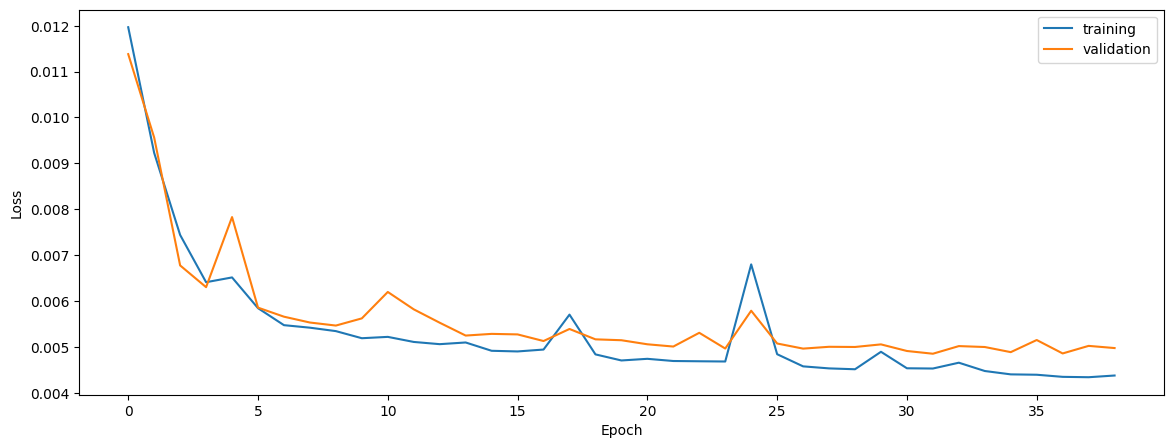

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7749224113827258
0.7740365183041112
0.7426336954979739


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7749224113827258
0.7740365183041112
0.7426336954979739


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.789115640539495
0.7868310336296207
0.7738987490954097


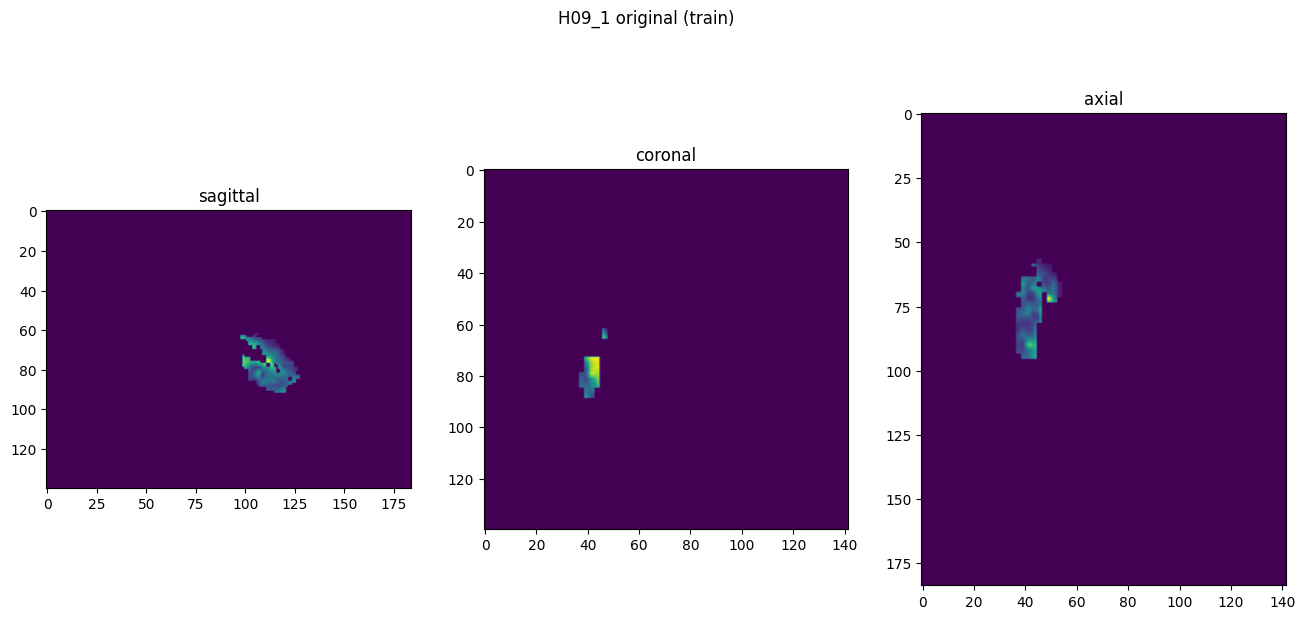

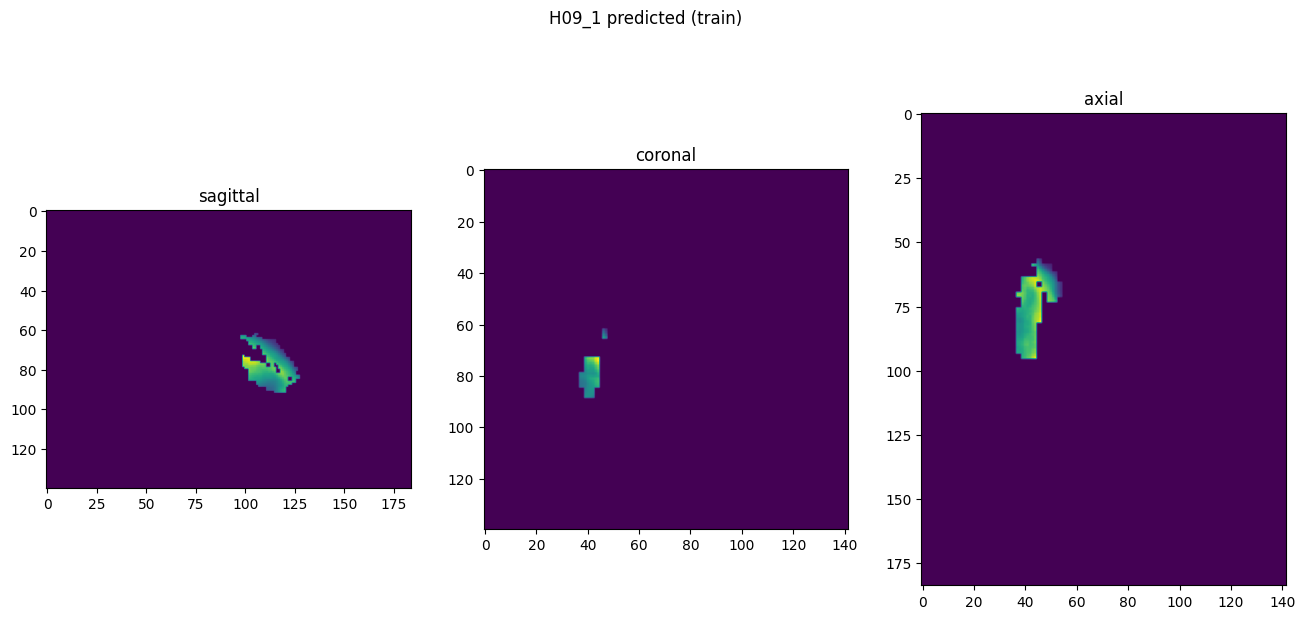

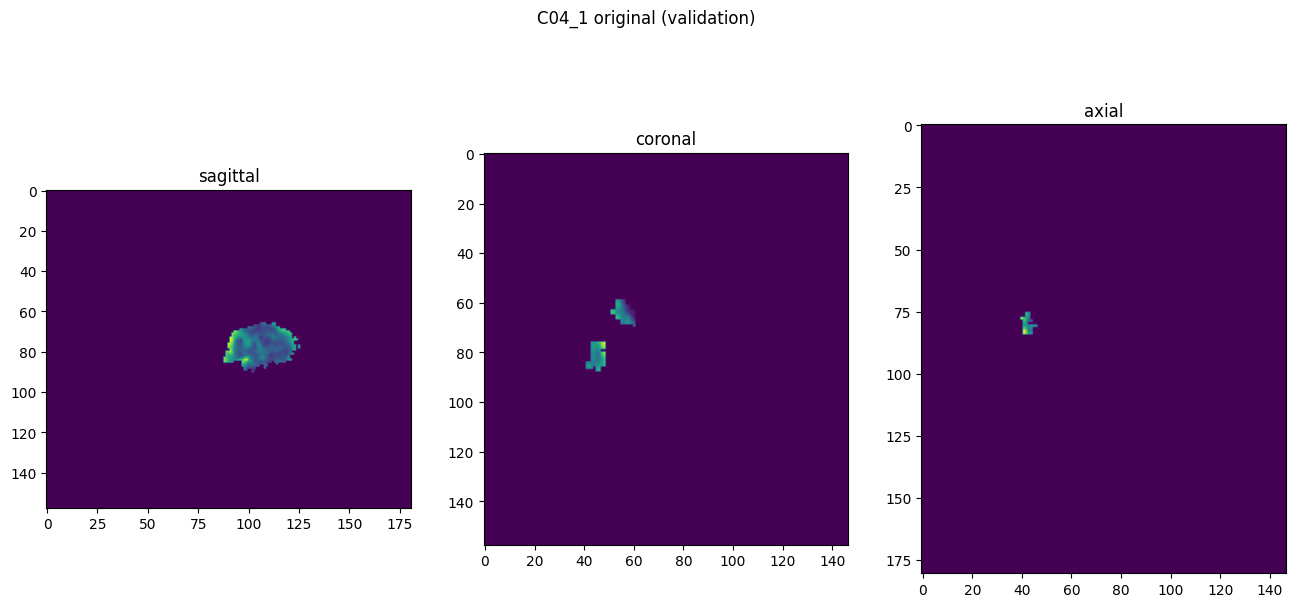

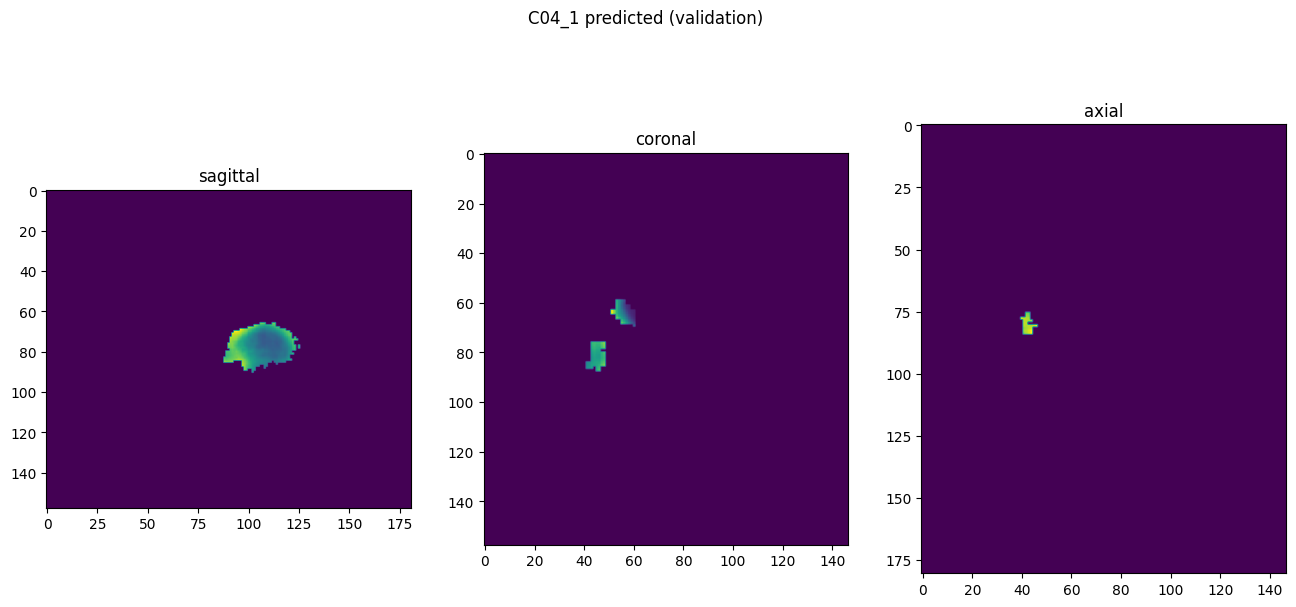

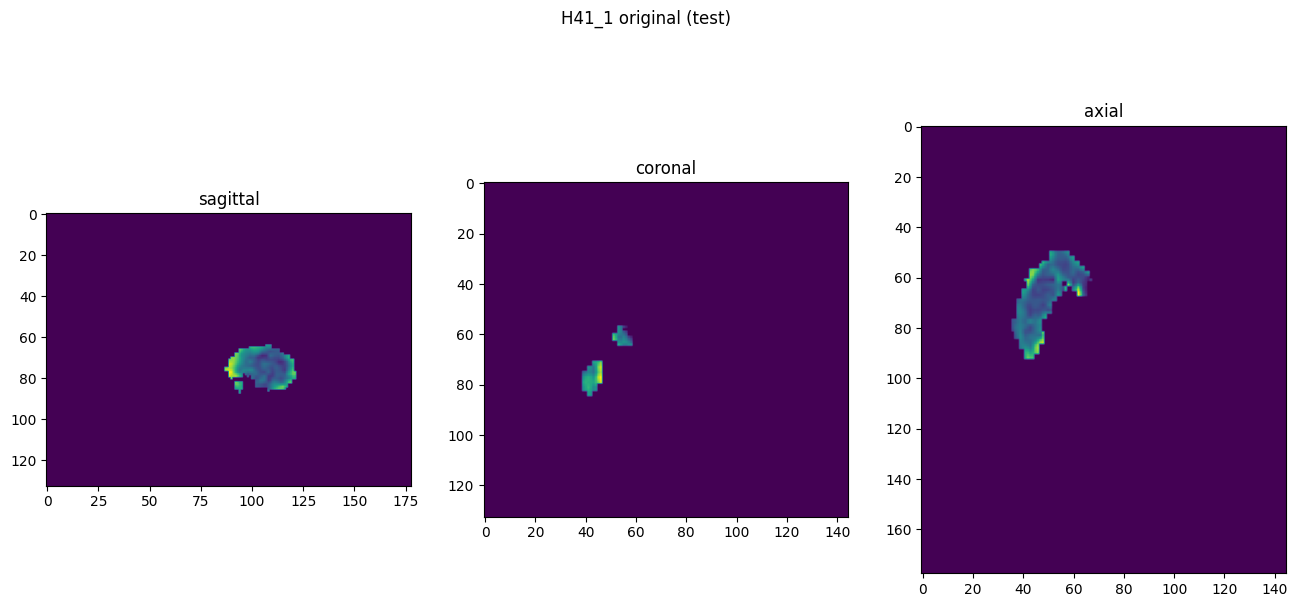

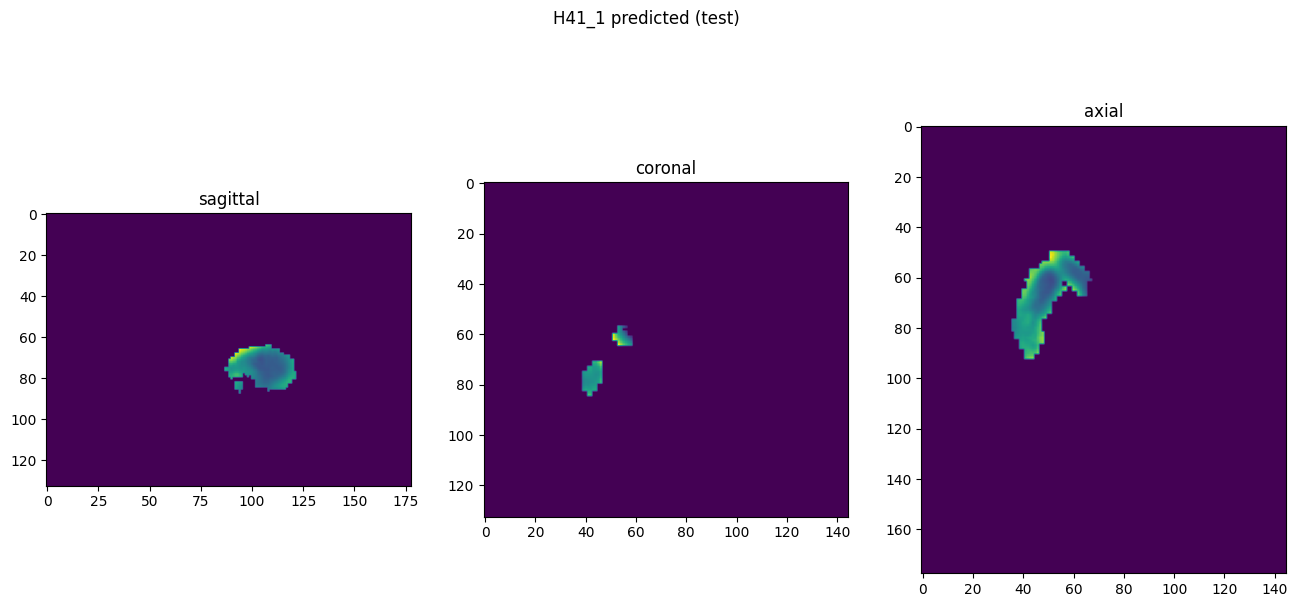

In [10]:
showResults(model, gen, threshold=None, background=False)